# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [40]:
import pandas as pd
import numpy as np

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [41]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [42]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [78]:
missing_data = sensor.isnull().sum()
missing_data

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [79]:
sensor.shape
print(f"there are {sensor.shape[0]} rows and {sensor.shape[1]} columns")

there are 1751 rows and 12 columns


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [80]:
time_series_index = pd.date_range(start="1/1/2018 00:00:00", end="1/1/2018 00:29:10", periods=sensor.shape[0])
time_series_index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

In [81]:
pd.infer_freq(time_series_index)

'S'

Assign the time series index to the dataframe's index.

In [92]:
sensor.index = time_series_index
sensor.index.name = "Time series"
pd.infer_freq(sensor.index)
#overwriting the freq:
sensor.index.freq = pd.infer_freq(sensor.index)
sensor.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', name='Time series', length=1751, freq='S')

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [ ]:
pip install statsmodels

In [70]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

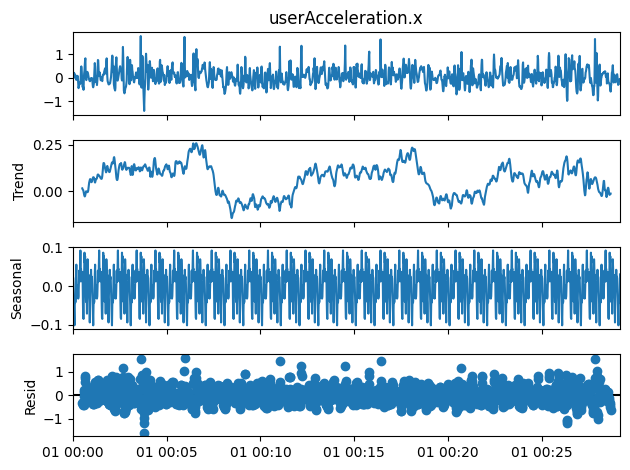

In [99]:
decomposition_userAccel_x = seasonal_decompose(sensor["userAcceleration.x"], period=60)
decomposition_userAccel_x.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

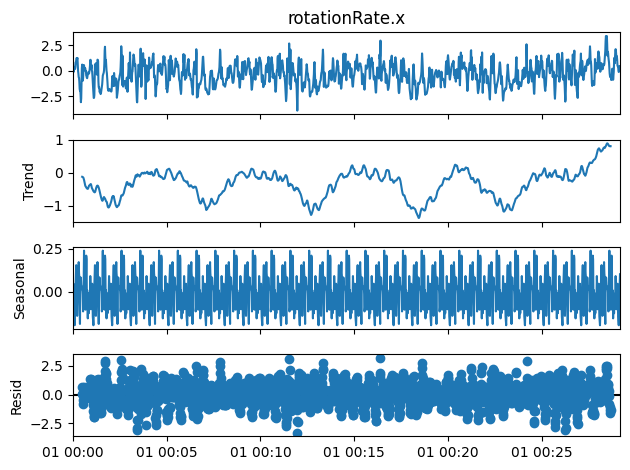

In [100]:
decomposition_rotationRate_x = seasonal_decompose(sensor["rotationRate.x"], period=60)
decomposition_rotationRate_x.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

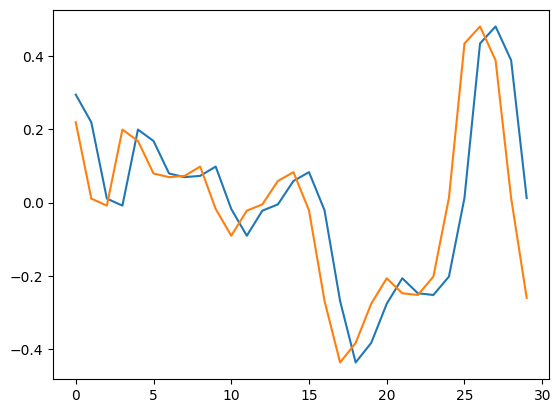

In [101]:
#assuming the lag of 1 observation:
user_accel_x = sensor["userAcceleration.x"][:-1]
userAcceleration_x_plus_1 = sensor["userAcceleration.x"][1:]
plt.plot(user_accel_x.values[:30], label="y(t)")
plt.plot(userAcceleration_x_plus_1.values[:30], label="y(t)");

Create a lag plot for `rotationRate.x`

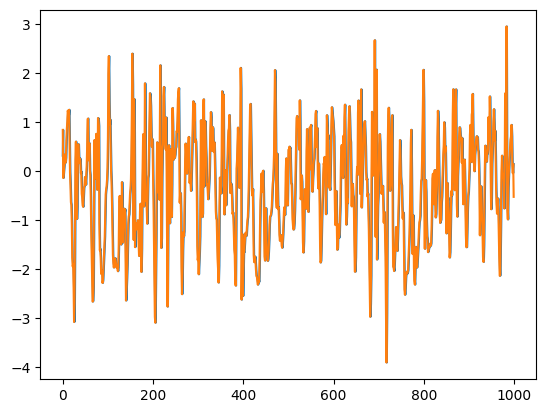

In [113]:
#also assuming the lag of 1 observation:   
rotation_rate_x = sensor["rotationRate.x"][:-1]
rotation_rate_x_plus_1 = sensor["rotationRate.x"][1:]
plt.plot(rotation_rate_x.values[:1000], label="y(t)")
plt.plot(rotation_rate_x_plus_1.values[:1000], label="y(t)");

What are your conclusions from both visualizations?

In [104]:
print("depending on what the values actually mean (for example, what does 0.316738 mean in the rotationRate.x) one second can make a relative big difference. This is especially relevant for the X rotation where one second can mean changing from -3 negative values to around 0/even positive ones")

depending on what the values actually mean (for example, what does 0.316738 mean in the rotationRate.x) one second can make a relative big difference. This is especially relevant for the X rotation where one second can mean changing from -3 negative values to around 0/even positive ones


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [106]:
𝐻0 = "The series is not stationary and there is a statistically significant trend"
𝐻𝐴 = "The series is stationary"

from statsmodels.tsa.stattools import adfuller
difu_stat_test_user_accel_x = adfuller(sensor["userAcceleration.x"])
difu_stat_test_rotation_rate_x = adfuller(sensor["rotationRate.x"])

p_value_difu_stat_test_user_accel_x = difu_stat_test_user_accel_x[1]
p_value_difu_stat_test_rotation_rate_x = difu_stat_test_rotation_rate_x[1]

alpha = 0.05

In [111]:
print(f"{p_value_difu_stat_test_user_accel_x}")
print(f"{p_value_difu_stat_test_rotation_rate_x}")

2.823439483037483e-30
6.320230335912605e-06


In [107]:
#for user_accel_x
if p_value_difu_stat_test_user_accel_x < alpha:
    print(f"we reject H0, indeed: {𝐻𝐴}")
else:
    print(f"we accept H0, indeed: {𝐻0}")

we reject H0, indeed: The series is stationary


In [108]:
#for rotation_rate_x
if p_value_difu_stat_test_rotation_rate_x < alpha:
    print(f"we reject H0, indeed: {𝐻𝐴}")
else:
    print(f"we accept H0, indeed: {𝐻0}")

we reject H0, indeed: The series is stationary


What are your conclusions from this test?

In [114]:
print("well, contrary to my initial guess, I was expecting the time series to be non stationary but the result returned otherwise. Then I increased the x-axis in the charts and realized that indeed the lines plotted around 0 without a clear trend, meaning there is indeed stationarity in the ts")


well, contrary to my initial guess, I was expecting the time series to be non stationary but the result returned otherwise. Then I increased the x-axis in the charts and realized that indeed the lines plotted around 0 without a clear trend, meaning there is indeed stationarity in the ts


## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [115]:
from statsmodels.tsa.arima.model import ARIMA
order = (2, 0, 1)

In [116]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [117]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
challenge_2_model = ARIMA(y_train, order = order, freq="S").fit()


In [ ]:
# 2. Fit the model:
challenge_2_model = ARIMA(y_train, order = order, freq="S").fit()

In [133]:
# 3. Predict: create y_pred:
y_pred = challenge_2_model.predict(start=len(y_train), end=len(y_train)+len(y_test))

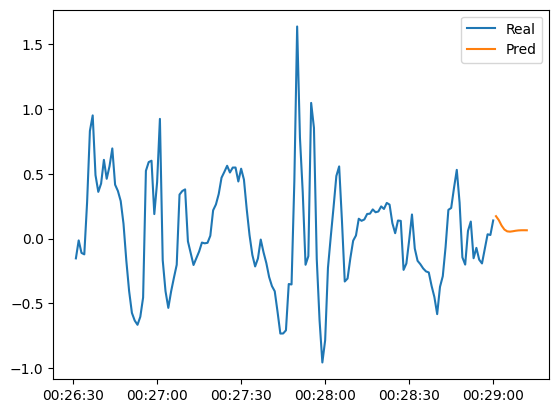

In [136]:
# 4. Visualize
plt.plot(y_train[-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Pred")
plt.legend()

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [16]:
# Your code here:

# rmse(y_pred, y_test)